In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
from scipy.optimize import minimize
import pygtc

## Esame TRMD: Analisi della distribuzione di miscentering di ammassi eRosita
Viel Axel [SM2001773]

## Prima parte: acquisizione dati

In [6]:
filename = 'catalog_selected_columns_filtered_with_cluster_index.csv'

data = pd.read_csv(filename)

In [8]:
data

,Unnamed: 0,NAME,RA_XFIT,DEC_XFIT,M500,R500,RA_OPT,DEC_OPT,RA_BCG,DEC_BCG,...,X_scaled_0,X_scaled_1,cluster,rho_m,rho_s,sigma0_m,sigma0_s,sigma1_m,sigma1_s,logM500
0,0,1eRASS J000005.2-383729,0.0214,-38.6250,36.07,971.0,0.023800,-38.626781,0.023800,-38.626781,...,-0.081623,0.778435,6,0.750582,0.027508,0.100183,0.007995,0.668959,0.040839,14.557146
1,1,1eRASS J000021.4-824954,0.0558,-82.8189,16.99,819.0,0.176800,-82.798203,0.176800,-82.798203,...,-1.230286,-0.425019,7,0.726530,0.026114,0.062899,0.005056,0.606223,0.031481,14.230193
2,2,1eRASS J000031.8-630131,0.1265,-63.0225,22.04,846.0,0.125400,-63.023071,0.125400,-63.023071,...,-0.439542,-0.046329,9,0.809312,0.024625,0.089089,0.006957,0.578245,0.038856,14.343212
3,3,1eRASS J000056.7-682010,0.2309,-68.3369,14.25,732.0,0.230100,-68.336777,0.176500,-68.372871,...,-0.456453,-0.657230,26,0.779278,0.026525,0.103519,0.008066,0.620830,0.038000,14.153815
4,4,1eRASS J000104.0-464435,0.2768,-46.7381,23.84,891.0,0.284000,-46.734661,0.284000,-46.734661,...,-0.809294,0.075927,22,0.779619,0.029719,0.058439,0.005577,0.514526,0.037597,14.377306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7562,7703,1eRASS J235805.6-403027,359.5230,-40.5073,11.51,692.0,359.557709,-40.486210,359.557709,-40.486210,...,-0.670809,-0.913151,26,0.779278,0.026525,0.103519,0.008066,0.620830,0.038000,14.061075
7563,7704,1eRASS J235848.7-612554,359.7070,-61.4319,21.82,800.0,359.700287,-61.433041,359.700287,-61.433041,...,0.278480,-0.061689,29,0.768367,0.033628,0.181056,0.018008,0.775150,0.052974,14.338855
7564,7705,1eRASS J235858.0-603644,359.6968,-60.6172,38.67,1071.0,359.767090,-60.609489,359.618896,-60.563850,...,-1.148322,0.905424,2,0.730593,0.032936,0.039728,0.003903,0.506667,0.035547,14.587374
7565,7706,1eRASS J235927.5-341821,359.8642,-34.3077,14.11,763.0,359.865387,-34.306438,359.865387,-34.306438,...,-1.104801,-0.669692,7,0.726530,0.026114,0.062899,0.005056,0.606223,0.031481,14.149527


In [10]:
#data acquisition
BEST_Z = data['BEST_Z'].values
logM500 = data['logM500'].values
BCG_offset_R500 = data['BCG_offset_R500'].values


Si crea un grafico logM500 - BCG_offset_R500 con una differenziazione per valori di BEST_Z.

Si può notare una tendenza: all'aumentare del redshift le galassie tendono a raggrupparsi nella zona in basso a destra del grafico, con BCG_offset_R500 basso e logM500 intorno al valore di 14.5

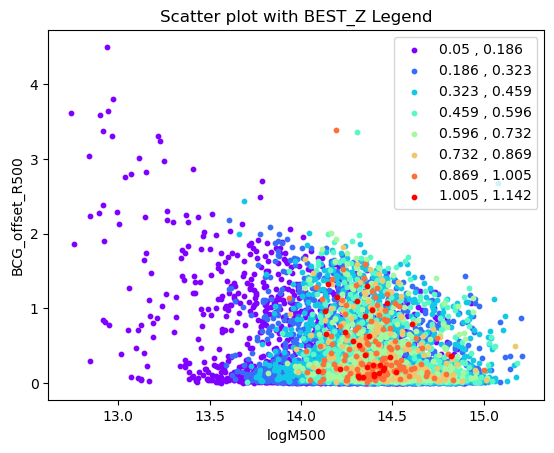

In [13]:
N_entries = 8

Z_min, Z_max = np.min(BEST_Z), np.max(BEST_Z)

col_range = np.linspace(Z_min, Z_max, N_entries + 1) #creo i diversi colori per ogni range

colors = plt.cm.rainbow(np.linspace(0, 1, N_entries))

for i in range(N_entries):
   mask = (BEST_Z >= col_range[i]) & (BEST_Z <= col_range[i + 1])
   legend_label =   np.round(col_range[i], 3) , np.round(col_range[i + 1], 3) 
   plt.scatter(logM500[mask], BCG_offset_R500[mask], s = 10, label = '{} , {}'.format( legend_label[0], legend_label[1] ), color = colors[i] )
    
plt.title('Scatter plot with BEST_Z Legend')
plt.xlabel('logM500')
plt.ylabel('BCG_offset_R500')

plt.legend(loc = 'upper right', ncol = 1)
plt.show()

Si è fatto un istogramma dei valori di BCG_offset_R500, dividendolo poi in 2 diversi istogrammi secondo un valore di soglia:
ciò permette di osservare il numero di elementi presenti nella coda dell'istogramma.

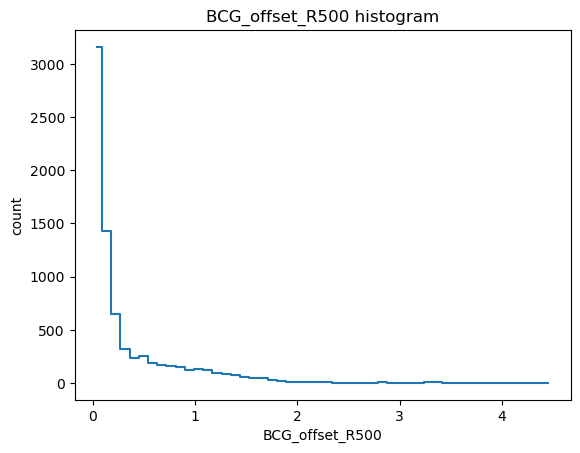


The number of elements with BCG_offset_R500 < 2.3 is:  7544
The number of elements with BCG_offset_R500 >= 2.3 is:  23
on a total set of 7567 elements



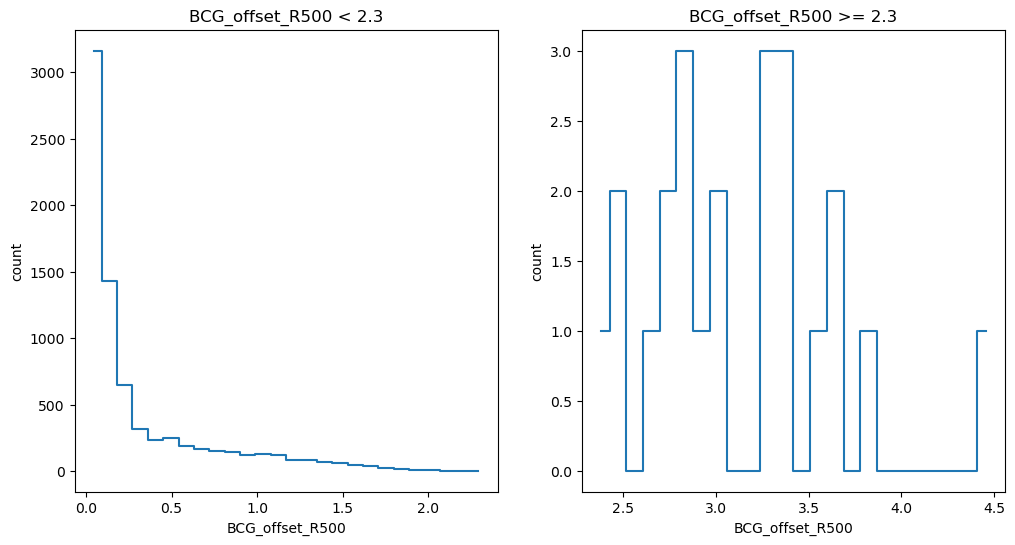

In [16]:
N_bins = 50

threshold = 2.3

count_hist, bin_edges = np.histogram(BCG_offset_R500, bins = N_bins, density = False) 

bin_center = np.zeros(N_bins) #initialization


for i in range(N_bins):
        bin_center[i] = ( bin_edges[i] + bin_edges[i+1] ) /2. 

plt.step(bin_center, count_hist, data=None, where='mid')

plt.title('BCG_offset_R500 histogram')
plt.xlabel('BCG_offset_R500')
plt.ylabel('count')

plt.show()

print()
print('The number of elements with BCG_offset_R500 < {} is: '.format(threshold), np.sum(count_hist[bin_edges[:-1]<threshold]))
print('The number of elements with BCG_offset_R500 >= {} is: '.format(threshold), np.sum(count_hist[bin_edges[:-1]>=threshold]))
print('on a total set of {} elements'.format(np.shape(BCG_offset_R500)[0]))
print()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].step(bin_center[bin_edges[:-1]<threshold], count_hist[bin_edges[:-1]<threshold], data=None, where='mid')
ax[0].set_title('BCG_offset_R500 < {}'.format(threshold))
ax[0].set_xlabel('BCG_offset_R500')
ax[0].set_ylabel('count')

ax[1].step(bin_center[bin_edges[:-1]>=threshold], count_hist[bin_edges[:-1]>=threshold], data=None, where='mid')
ax[1].set_title('BCG_offset_R500 >= {}'.format(threshold))
ax[1].set_xlabel('BCG_offset_R500')
ax[1].set_ylabel('count')

plt.show()



Si creano degli ulteriori istogrammi per evidenziare la variazione della distibuzione di BCG_offset_R500 per determinati range di BEST_Z e logM500.

Si noti che, nel primo plot, le galassie ad alto redshift sono una minoranza, mentre quelle a basso redshift sono le più popolose.

Si noti anche come, nel secondo plot, le galassie meno massive sono anche le meno popolose, ma ricoprono anche i valori più alti di BCG_offset_R500.

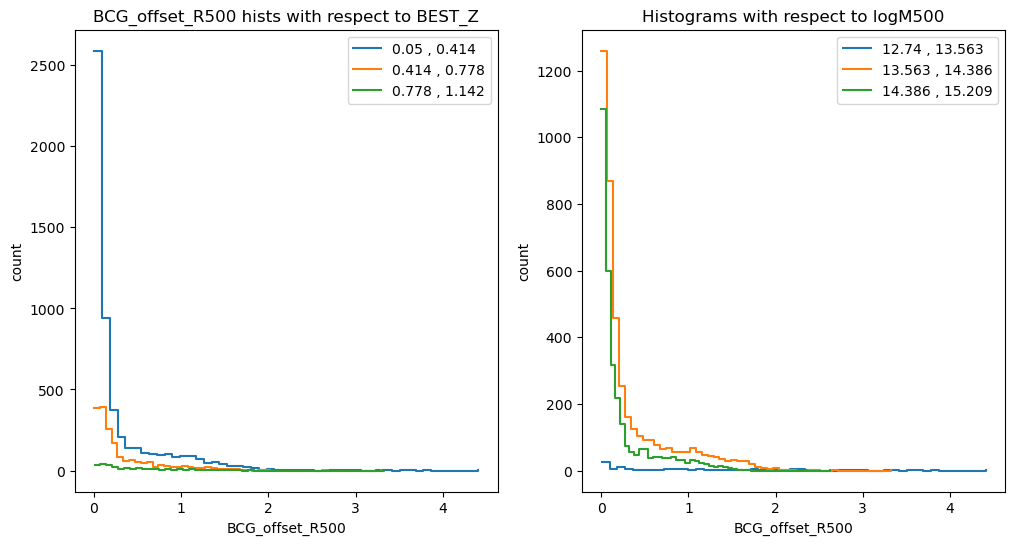

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

N_entries = 3
N_bins = 50

Z_min, Z_max = np.min(BEST_Z), np.max(BEST_Z)
logM500_min, logM500_max = np.min(logM500), np.max(logM500)

Z_range = np.linspace(Z_min, Z_max, N_entries + 1) 
logM500_range = np.linspace(logM500_min, logM500_max, N_entries + 1)

for i in range(N_entries):

    Z_mask = (BEST_Z >= Z_range[i]) & (BEST_Z <= Z_range[i + 1])
    Z_label =   np.round(Z_range[i], 3) , np.round(Z_range[i + 1], 3)

    Z_hist, Z_bin_edges = np.histogram(BCG_offset_R500[Z_mask], bins = N_bins, density = False)
    ax[0].step(Z_bin_edges[:-1], Z_hist, data=None, where='post',  label = '{} , {}'.format( Z_label[0], Z_label[1] ))
    
    logM500_mask = (logM500 >= logM500_range[i]) & (logM500 <= logM500_range[i + 1])
    logM500_label =   np.round(logM500_range[i], 3) , np.round(logM500_range[i + 1], 3)
    
    logM500_hist, logM500_bin_edges = np.histogram(BCG_offset_R500[logM500_mask], bins = N_bins, density = False)
    ax[1].step(logM500_bin_edges[:-1], logM500_hist, data=None, where='post',  label = '{} , {}'.format( logM500_label[0], logM500_label[1] ))
    
ax[0].set_title('BCG_offset_R500 hists with respect to BEST_Z')
ax[0].set_xlabel('BCG_offset_R500')
ax[0].set_ylabel('count')
ax[0].legend(loc = 'upper right', ncol = 1)

ax[1].set_title('Histograms with respect to logM500')
ax[1].set_xlabel('BCG_offset_R500')
ax[1].set_ylabel('count')
ax[1].legend(loc = 'upper right', ncol = 1)

plt.show()

## Seconda parte: sviluppo dei modelli

Questa sezione è fatta principalmente per definire i 2 modelli usati:
- $Mod_{S15} (x| \rho, \sigma_0, \sigma_1) = \rho  \frac{x}{\sigma_0^2} e^{- \frac{x^2}{ 2 \sigma_0^2}} + 
                                            (1-\rho)  \frac{x}{\sigma_1^2} e^{- \frac{x^2}{ 2 \sigma_1^2}}$
- $Mod_{Z19} (x| \rho, \sigma_0, \sigma_1) = \rho  \frac{1}{\sigma_0} e^{- \frac{x}{ \sigma_0}} + 
                                            (1-\rho)  \frac{x}{\sigma_1^2} e^{- \frac{x}{ \sigma_1}}$

Successivamente si sono calcolate le derivate parziali rispetto ai tre parametri, le quali saranno in seguito usate per propagare la varianza sui modelli.

In [23]:
def Mod_S15(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    centered = rho * x / np.power( sigma_0, 2 ) * np.exp( - 0.5 * np.power( x / sigma_0, 2 ) )
    miscentered = ( 1. - rho ) * x / np.power( sigma_1, 2 ) * np.exp( - 0.5 * np.power( x / sigma_1, 2 ) )
    value = centered + miscentered
    
    return value

def Mod_S15_cent(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    value = rho * x / np.power( sigma_0, 2 ) * np.exp( - 0.5 * np.power( x / sigma_0, 2 ) )
    
    return value

def Mod_S15_misc(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    value = ( 1. - rho ) * x / np.power( sigma_1, 2 ) * np.exp( - 0.5 * np.power( x / sigma_1, 2 ) )
    
    return value

def Drho_Mod_S15(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    centered = x / np.power( sigma_0, 2 ) * np.exp( - 0.5 * np.power( x / sigma_0, 2 ) )
    miscentered =  - x / np.power( sigma_1, 2 ) * np.exp( - 0.5 * np.power( x / sigma_1, 2 ) )
    value = centered + miscentered
    
    return value

def Dsigma0_Mod_S15(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    value = rho * x / np.power( sigma_0, 3 ) * np.exp( - 0.5 * np.power( x / sigma_0, 2 ) ) * ( np.power( x / sigma_0, 2 ) - 2 )
    
    return value

def Dsigma1_Mod_S15(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    value = ( 1. - rho ) * x / np.power( sigma_1, 3 ) * np.exp( - 0.5 * np.power( x / sigma_1, 2 ) ) * ( np.power( x / sigma_1, 2 ) - 2 )

    return value
#======================================================================================================================

def Mod_Z19(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    centered = rho / sigma_0 * np.exp( - x / sigma_0 )
    miscentered = ( 1 - rho ) * x / np.power( sigma_1, 2 ) * np.exp( - x / sigma_1 )
    value = centered + miscentered
    
    return value

def Mod_Z19_cent(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    value = rho / sigma_0 * np.exp( - x / sigma_0 )
    
    return value

def Mod_Z19_misc(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    value = ( 1 - rho ) * x / np.power( sigma_1, 2 ) * np.exp( - x / sigma_1 )
    
    return value

def Drho_Mod_Z19(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    centered = 1. / sigma_0 * np.exp( - x / sigma_0 )
    miscentered = - x / np.power( sigma_1, 2 ) * np.exp( - x / sigma_1 )
    value = centered + miscentered
    
    return value

def Dsigma0_Mod_Z19(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    value = rho / np.power(sigma_0, 2) * np.exp( - x / sigma_0 ) * ( ( x / sigma_0 ) - 1 )
    
    return value

def Dsigma1_Mod_Z19(x, rho, sigma_0, sigma_1):
    if ( np.abs( 0.5 - rho ) > 0.5 ) or ( sigma_0 <= 0. ) or ( sigma_1 <= 0. ) :
        return np.nan
    value = ( 1 - rho ) * x / np.power( sigma_1, 3 ) * np.exp( - x / sigma_1 ) * ( ( x / sigma_1 ) - 2 )
    
    return value

Si crea un grafico con il modello scelto, con certi valori dei parametri.

Si può notare dove le funzioni "centered" e "miscentered" danno un maggior contributo.

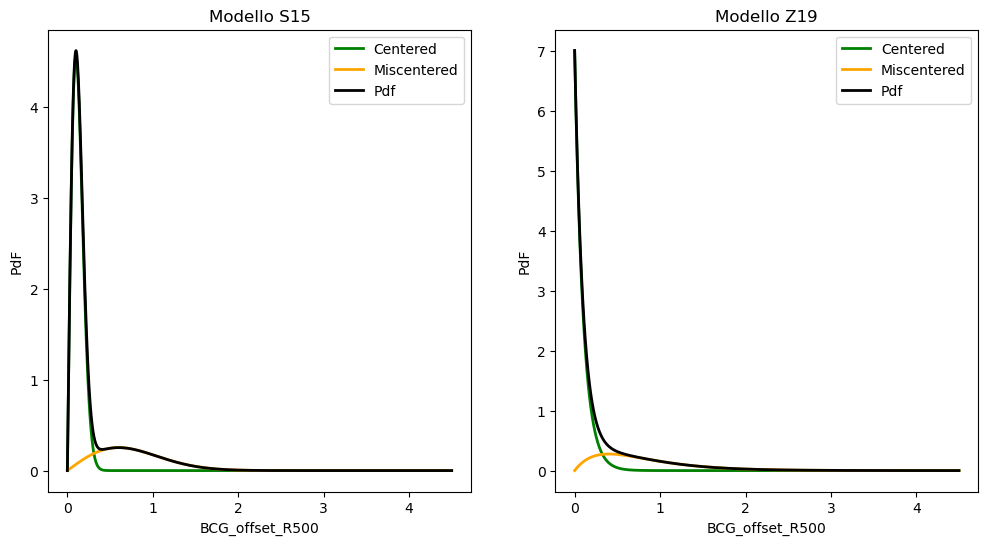

In [26]:
N = 2000

rho = 0.75
sigma_0 = 0.1
sigma_1 = 0.6

x_arr = np.linspace(0, np.max(BCG_offset_R500), N)

y_arr_S15 = np.zeros(N) #initialization
y_arr_cent_S15 = np.zeros(N) #initialization
y_arr_misc_S15 = np.zeros(N) #initialization

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(N):

    y_arr_S15[i] = Mod_S15(x_arr[i], rho, sigma_0, sigma_1)
    y_arr_cent_S15[i] = Mod_S15_cent(x_arr[i], rho, sigma_0, sigma_1)
    y_arr_misc_S15[i] = Mod_S15_misc(x_arr[i], rho, sigma_0, sigma_1)
    

ax[0].plot(x_arr, y_arr_cent_S15, alpha = 1.0, color = 'green', linewidth = 2, label = 'Centered')
ax[0].plot(x_arr, y_arr_misc_S15, alpha = 1.0, color = 'orange', linewidth = 2, label = 'Miscentered')
ax[0].plot(x_arr, y_arr_S15, linewidth = 2.0, color = 'black', label = 'Pdf')
ax[0].set_title('Modello S15')
ax[0].set_xlabel('BCG_offset_R500')
ax[0].set_ylabel('PdF')
ax[0].legend()

rho = 0.7
sigma_0 = 0.1
sigma_1 = 0.4

y_arr_Z19 = np.zeros(N) #initialization
y_arr_cent_Z19 = np.zeros(N) #initialization
y_arr_misc_Z19 = np.zeros(N) #initialization

for i in range(N):

    y_arr_Z19[i] = Mod_Z19(x_arr[i], rho, sigma_0, sigma_1)
    y_arr_cent_Z19[i] = Mod_Z19_cent(x_arr[i], rho, sigma_0, sigma_1)
    y_arr_misc_Z19[i] = Mod_Z19_misc(x_arr[i], rho, sigma_0, sigma_1)

ax[1].plot(x_arr, y_arr_cent_Z19, alpha = 1.0, color = 'green', linewidth = 2, label = 'Centered')
ax[1].plot(x_arr, y_arr_misc_Z19, alpha = 1.0, color = 'orange', linewidth = 2, label = 'Miscentered')
ax[1].plot(x_arr, y_arr_Z19, linewidth = 2.0, color = 'black', label = 'Pdf')
ax[1].set_title('Modello Z19')
ax[1].set_xlabel('BCG_offset_R500')
ax[1].set_ylabel('PdF')
ax[1].legend()

plt.show()
    

## Terza parte: Analisi Dati

L'analisi bayesiana parte dalla definizione della LogPosterior, definita come la somma della LogPrior e della LogLikelihood.
- La LogPrior è creata in modo da rappresentare una distribuzione uniforme, dato che $log(1) = 0$, nel caso in cui le condizioni sui parametri siano sodisfatte, in aso contrario rappresenterà una distribuzione nulla, dato che $log(0) = - \infty$,.
- La LogLikelihood è definita come $\sum_i ln( \  MOD \ (x_i| \rho, \sigma_0, \sigma_1) )$

In [30]:
def log_prior_S15(theta):
    rho, sigma_0, sigma_1 = theta
    if ( sigma_0 > 0 ) and ( sigma_1 > 0 ) and ( np.abs( rho - 0.5) <= 0.5 ):
        return 0.0
    return -np.inf

def log_likelihood_S15(theta, x):
    rho, sigma_0, sigma_1 = theta

    value = 0.
    for i in range(np.shape(x)[0]):
        value = value + np.log( Mod_S15(x[i], rho, sigma_0, sigma_1) )
    return value

def log_posterior_S15(theta, x):
    lp = log_prior_S15(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_S15(theta, x)

In [32]:
def log_prior_Z19(theta):
    rho, sigma_0, sigma_1 = theta
    if ( sigma_0 > 0 ) and ( sigma_1 > 0 ) and ( np.abs( rho - 0.5) <= 0.5 ):
        return 0.0
    return -np.inf

def log_likelihood_Z19(theta, x):
    rho, sigma_0, sigma_1 = theta

    value = 0.
    for i in range(np.shape(x)[0]):
        value += np.log( Mod_Z19(x[i], rho, sigma_0, sigma_1) )
    return value

def log_posterior_Z19(theta, x):
    lp = log_prior_Z19(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_Z19(theta, x)

Con la funzione "minimize" di scipy si cercano i parametri $(\rho, \sigma_0, \sigma_1)$ che massimizzano la LogPosterior

In [63]:
nll = lambda * args: -log_posterior_S15(*args)

initial = np.array([0.7, 0.5, 0.5]) * ( 1 + 0.001 * np.random.randn(3))
soln_S15 = minimize( nll, initial, args = ( BCG_offset_R500 ) )
rho_bf_S15, sigma_0_bf_S15, sigma_1_bf_S15 = soln_S15.x
soln_S15.x

C:\Users\Axel\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Axel\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


array([0.62825884, 0.06699864, 0.62301053])

In [64]:
nll = lambda * args: -log_posterior_Z19(*args)

initial = np.array([0.7, 0.5 , 0.5]) * ( 1 + 0.001 * np.random.randn(3))
soln_Z19 = minimize( nll, initial, args = ( BCG_offset_R500 ) )
rho_bf_Z19, sigma_0_bf_Z19, sigma_1_bf_Z19 = soln_Z19.x
soln_Z19.x

C:\Users\Axel\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Axel\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Axel\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


array([0.68042447, 0.0986946 , 0.39151591])

Si fa un plot della funzione di fit con i parametri ottenuti assieme alla distribuzione reale delle distanze normalizzate.

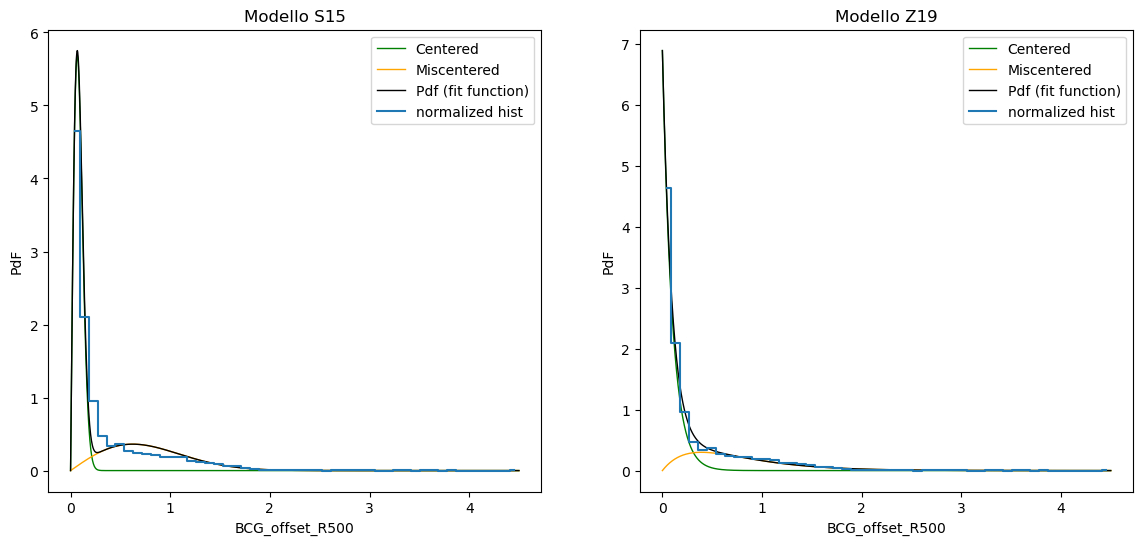

In [67]:
N = 2000

N_bins = 50

hist, bin_edges = np.histogram(BCG_offset_R500, bins = N_bins, density = True) 


bin_center = np.zeros(N_bins)


for i in range(N_bins):
        bin_center[i] = ( bin_edges[i] + bin_edges[i+1] ) /2. 


for i in range(N):

    y_arr_S15[i] = Mod_S15(x_arr[i], rho_bf_S15, sigma_0_bf_S15, sigma_1_bf_S15)
    y_arr_cent_S15[i] = Mod_S15_cent(x_arr[i], rho_bf_S15, sigma_0_bf_S15, sigma_1_bf_S15)
    y_arr_misc_S15[i] = Mod_S15_misc(x_arr[i], rho_bf_S15, sigma_0_bf_S15, sigma_1_bf_S15)
    
    y_arr_Z19[i] = Mod_Z19(x_arr[i], rho_bf_Z19, sigma_0_bf_Z19, sigma_1_bf_Z19)
    y_arr_cent_Z19[i] = Mod_Z19_cent(x_arr[i], rho_bf_Z19, sigma_0_bf_Z19, sigma_1_bf_Z19)
    y_arr_misc_Z19[i] = Mod_Z19_misc(x_arr[i], rho_bf_Z19, sigma_0_bf_Z19, sigma_1_bf_Z19)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(x_arr, y_arr_cent_S15, alpha = 1.0, color = 'green', linewidth = 1, label = 'Centered')
ax[0].plot(x_arr, y_arr_misc_S15, alpha = 1.0, color = 'orange', linewidth = 1, label = 'Miscentered')
ax[0].plot(x_arr, y_arr_S15, linewidth = 1.0, color = 'black', label = 'Pdf (fit function)')
ax[0].step(bin_center, hist, data=None, where='mid', label = 'normalized hist')
ax[0].legend()
ax[0].set_title('Modello S15')
ax[0].set_xlabel('BCG_offset_R500')
ax[0].set_ylabel('PdF')

ax[1].plot(x_arr, y_arr_cent_Z19, alpha = 1.0, color = 'green', linewidth = 1, label = 'Centered')
ax[1].plot(x_arr, y_arr_misc_Z19, alpha = 1.0, color = 'orange', linewidth = 1, label = 'Miscentered')
ax[1].plot(x_arr, y_arr_Z19, linewidth = 1.0, color = 'black', label = 'Pdf (fit function)')
ax[1].step(bin_center, hist, data=None, where='mid', label = 'normalized hist')
ax[1].legend()
ax[1].set_title('Modello Z19')
ax[1].set_xlabel('BCG_offset_R500')
ax[1].set_ylabel('PdF')

plt.show()

Grazie all'algoritmo emcee si esplora lo spazio dei parametri, creando i relativi campioni.
Vengono usati 10 walkers, per 2000 steps, con un burn-in di 100 steps

In [70]:
pos_S15 = soln_S15.x *(1+ 1e-4 * np.random.randn(10, 3))
nwalkers, ndim = pos_S15.shape

sampler_S15 = emcee.EnsembleSampler( nwalkers, ndim, log_posterior_S15, args=( BCG_offset_R500, ) )

sampler_S15.run_mcmc(pos_S15, 2000, progress=True);

100%|██████████| 2000/2000 [51:43<00:00,  1.55s/it]


In [74]:
pos_Z19 = soln_Z19.x *(1+ 1e-4 * np.random.randn(10, 3))
nwalkers, ndim = pos_Z19.shape

sampler_Z19 = emcee.EnsembleSampler( nwalkers, ndim, log_posterior_Z19, args=( BCG_offset_R500, ) )

sampler_Z19.run_mcmc(pos_Z19, 2000, progress=True);

100%|██████████| 2000/2000 [29:29<00:00,  1.13it/s]


Successivamente si plottano i percorsi dei 10 walkers per ogni parametro, verificando che essi siano simili ad un segnale di rumore

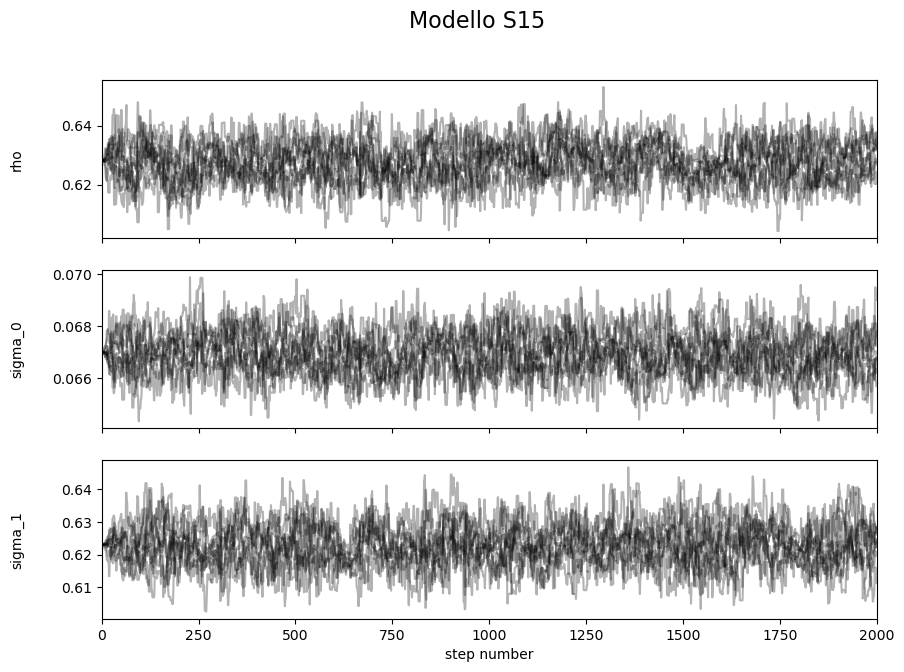

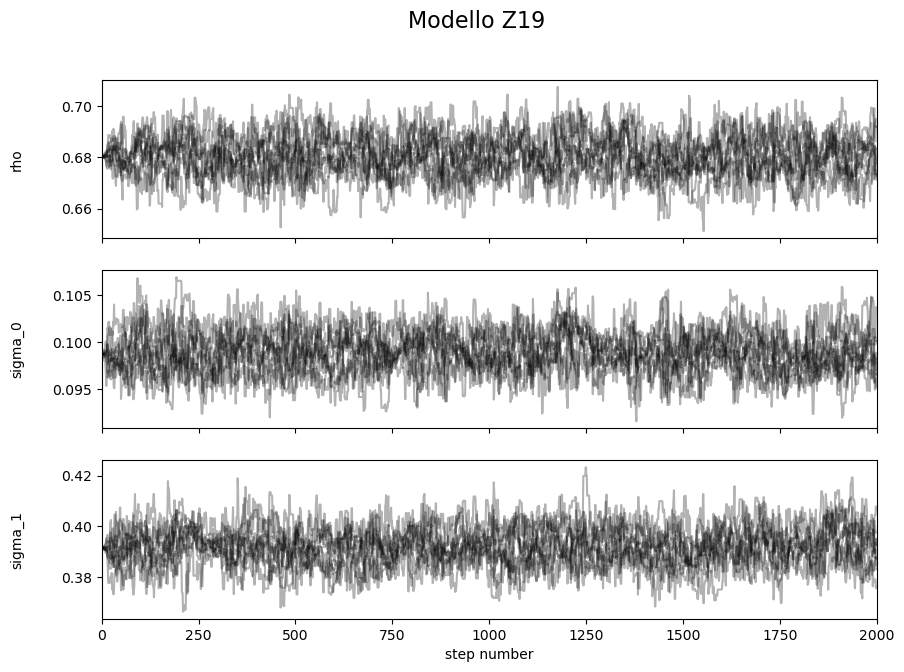

In [76]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
fig.suptitle('Modello S15', fontsize=16)
samples_S15 = sampler_S15.get_chain()
labels = ["rho","sigma_0", "sigma_1"]  #il problema è il nome
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_S15[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_S15))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
fig.suptitle('Modello Z19', fontsize=16)
samples_Z19 = sampler_Z19.get_chain()
labels = ["rho","sigma_0", "sigma_1"]  #il problema è il nome
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_Z19[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_Z19))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");



Si uniscono i campioni per ogni set di walkers, creando un array bidimensionale contenente i campioni totali di $\rho$, $\sigma_0$ e $\sigma_1$.
Grazie alla libreria pygtc si possono graficare le distribuzioni dei singoli e delle 3 coppie di parametri.

samples dimension: (19000, 3)
samples dimension: (19000, 3)


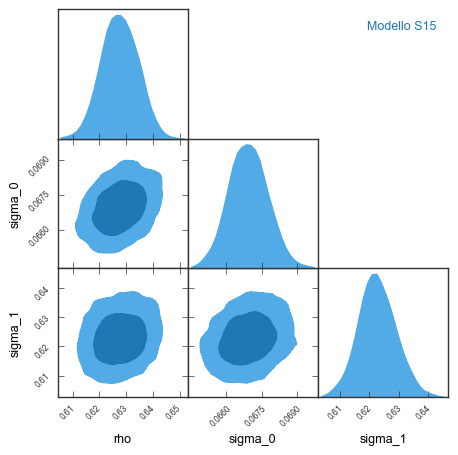

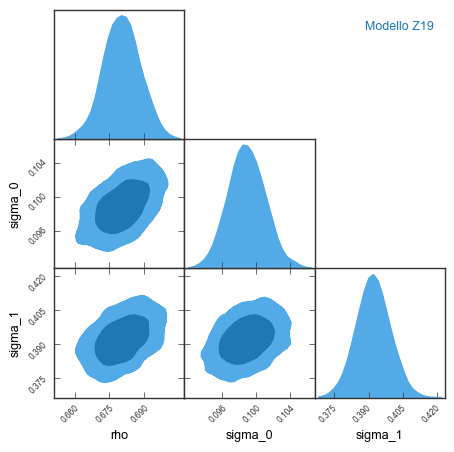

In [78]:
flat_samples_S15 = sampler_S15.get_chain(discard=100, flat=True)
print('samples dimension:', flat_samples_S15.shape)

GTC = pygtc.plotGTC(chains=flat_samples_S15,
                    paramNames=['rho', 'sigma_0', 'sigma_1'],
                    chainLabels=['Modello S15'],
                    figureSize='MNRAS_page')

flat_samples_Z19 = sampler_Z19.get_chain(discard=100, flat=True)
print("samples dimension:", flat_samples_Z19.shape)

GTC = pygtc.plotGTC(chains=flat_samples_Z19,
                    paramNames=['rho', 'sigma_0', 'sigma_1'],
                    chainLabels=['Modello Z19'],
                    figureSize='MNRAS_page')

Dall'array dei campioni si calcolano:
- la matrice delle correlazioni, per capire quanto siano correlati fra loro i parametri;
- il vettore delle incertezze sui parametri;
- la matrice delle covarianze (ottenibile anche dai due precedenti elementi), per propagare la varianza sul modello usato.

Con la formula della propagazione delle varianze si ottiene, per ogni valore delle distanze normalizzate, la varianza associata e quindi l'incertezza.

Si può notare già con questo semplice grafico quanto la varianza diventi infinitesima all'aumentare della distanza normalizzata.

In più si noti che (ovviamente, dato che la varianza dipende dalle derivate dei modelli) la varianza del modello S15 decresce come $e^{-x^2}$, mentre la varianza del modello Z19 decresce come $e^{-x}$, quindi più lentamente.

Modello S15

Correlation matrix:
[[1.         0.34373509 0.19884904]
 [0.34373509 1.         0.2563385 ]
 [0.19884904 0.2563385  1.        ]]

Parameters standard deviations:
[0.00657466 0.00079801 0.00626245]

Covariance matrix:
[[4.32284044e-05 1.80355424e-06 8.18773415e-06]
 [1.80355424e-06 6.36856323e-07 1.28112114e-06]
 [8.18773415e-06 1.28112114e-06 3.92203319e-05]]


Modello Z19

Correlation matrix:
[[1.         0.50766682 0.45483841]
 [0.50766682 1.         0.3707165 ]
 [0.45483841 0.3707165  1.        ]]

Parameters standard deviations:
[0.00771226 0.00213537 0.00724665]

Covariance matrix:
[[5.94821478e-05 8.36098930e-06 2.54213667e-05]
 [8.36098930e-06 4.56006610e-06 5.73688213e-06]
 [2.54213667e-05 5.73688213e-06 5.25166353e-05]]



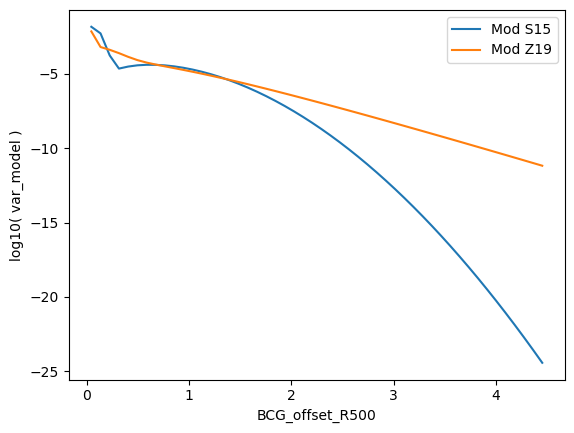

In [81]:
corr_matrix_S15 = np.corrcoef(flat_samples_S15.T)

sigma_params_S15 = np.zeros(flat_samples_S15.shape[1]) #initialization

for i in range(flat_samples_S15.shape[1]):
    sigma_params_S15[i] = np.std(flat_samples_S15[:,i])

print("Modello S15")
print()
print("Correlation matrix:")
print(corr_matrix_S15)
print()
print("Parameters standard deviations:")
print(sigma_params_S15)
print()

cov_matrix_S15 = np.cov(flat_samples_S15.T)

print("Covariance matrix:")
print(cov_matrix_S15)
print()
print()

corr_matrix_Z19 = np.corrcoef(flat_samples_Z19.T)

sigma_params_Z19 = np.zeros(flat_samples_Z19.shape[1]) #initialization

for i in range(flat_samples_Z19.shape[1]):
    sigma_params_Z19[i] = np.std(flat_samples_Z19[:,i])

print("Modello Z19")
print()
print("Correlation matrix:")
print(corr_matrix_Z19)
print()
print("Parameters standard deviations:")
print(sigma_params_Z19)
print()

cov_matrix_Z19 = np.cov(flat_samples_Z19.T)

print("Covariance matrix:")
print(cov_matrix_Z19)
print()


y_arr_S15 = np.zeros(N_bins) #initialization

var_model_S15 = np.zeros(N_bins) #initialization

Diff_S15 = np.zeros([N_bins,3]) #initialization

y_arr_Z19 = np.zeros(N_bins) #initialization

var_model_Z19 = np.zeros(N_bins) #initialization

Diff_Z19 = np.zeros([N_bins,3]) #initialization


for i in range(N_bins):

    y_arr_S15[i] = Mod_S15(bin_center[i], rho_bf_S15, sigma_0_bf_S15, sigma_1_bf_S15)
    
    Diff_S15[i, 0] = Drho_Mod_S15(bin_center[i], rho_bf_S15, sigma_0_bf_S15, sigma_1_bf_S15)
    Diff_S15[i, 1] = Dsigma0_Mod_S15(bin_center[i], rho_bf_S15, sigma_0_bf_S15, sigma_1_bf_S15)
    Diff_S15[i, 2] = Dsigma1_Mod_S15(bin_center[i], rho_bf_S15, sigma_0_bf_S15, sigma_1_bf_S15)

    y_arr_Z19[i] = Mod_Z19(bin_center[i], rho_bf_Z19, sigma_0_bf_Z19, sigma_1_bf_Z19)
    
    Diff_Z19[i, 0] = Drho_Mod_Z19(bin_center[i], rho_bf_Z19, sigma_0_bf_Z19, sigma_1_bf_Z19)
    Diff_Z19[i, 1] = Dsigma0_Mod_Z19(bin_center[i], rho_bf_Z19, sigma_0_bf_Z19, sigma_1_bf_Z19)
    Diff_Z19[i, 2] = Dsigma1_Mod_Z19(bin_center[i], rho_bf_Z19, sigma_0_bf_Z19, sigma_1_bf_Z19)

    a = 0. #initialization
    b = 0. #initialization
    
    for j in range(2):
        for k in range(2):
                a += cov_matrix_S15[j,k] * np.abs ( Diff_S15[i, j] * Diff_S15[i, k] )
                b += cov_matrix_Z19[j,k] * np.abs ( Diff_Z19[i, j] * Diff_Z19[i, k] )
    
    var_model_S15[i] = a
    var_model_Z19[i] = b

plt.plot(bin_center, np.log10(var_model_S15), label = "Mod S15" )
plt.plot(bin_center, np.log10(var_model_Z19), label = "Mod Z19" )
plt.xlabel('BCG_offset_R500')
plt.ylabel('log10( var_model )')

plt.legend()
plt.show()

Si calcola successivamente il $\chi^2_{red}$ come parametro di bontà del fit, mostrando i contributi delle varie componenti nei grafici.

Si è scelto di porre un valore di soglia nelle distanze normalizzate, mostrando il contributo al valore del $\chi^2_{red}$ dato dai valori sotto e sopra la soglia.

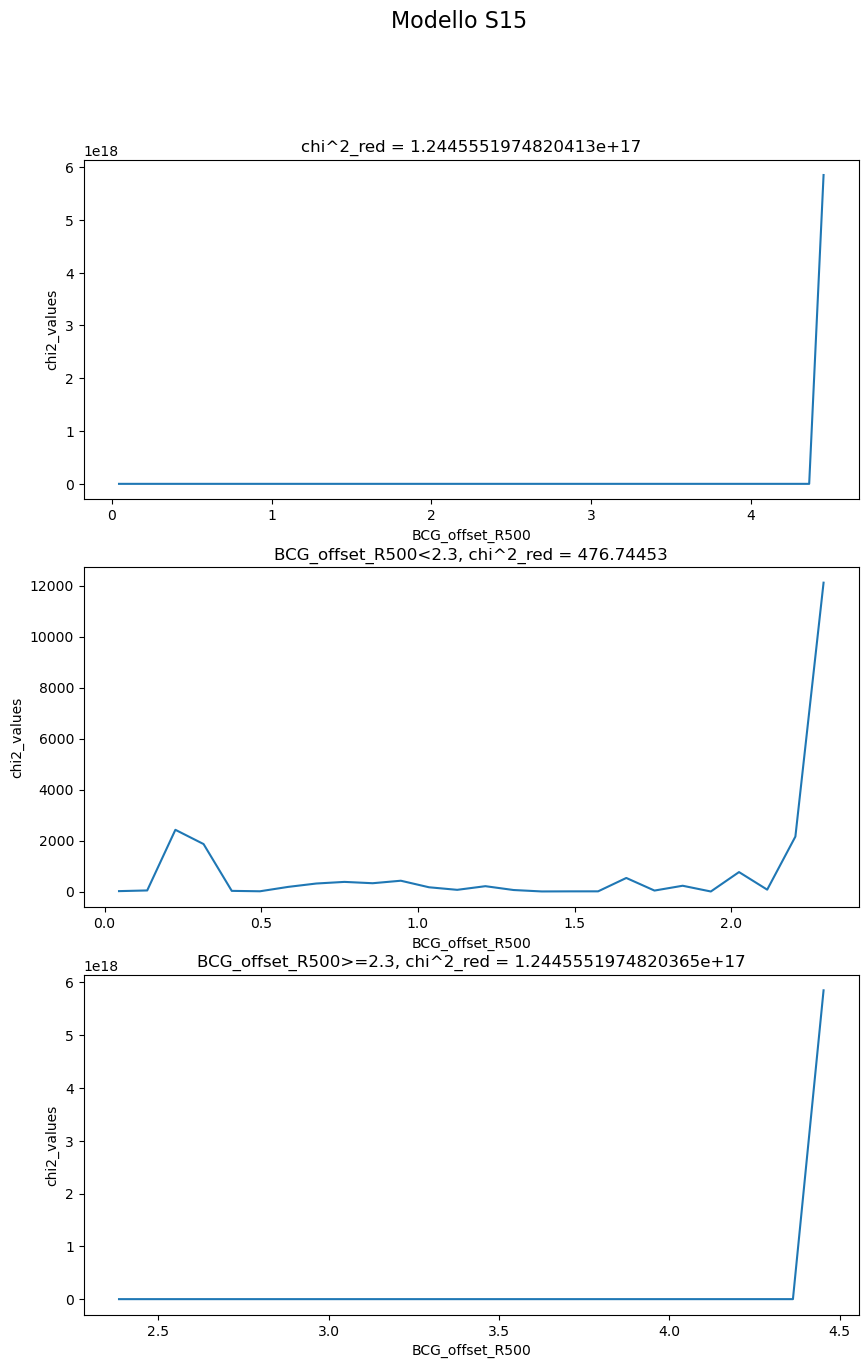

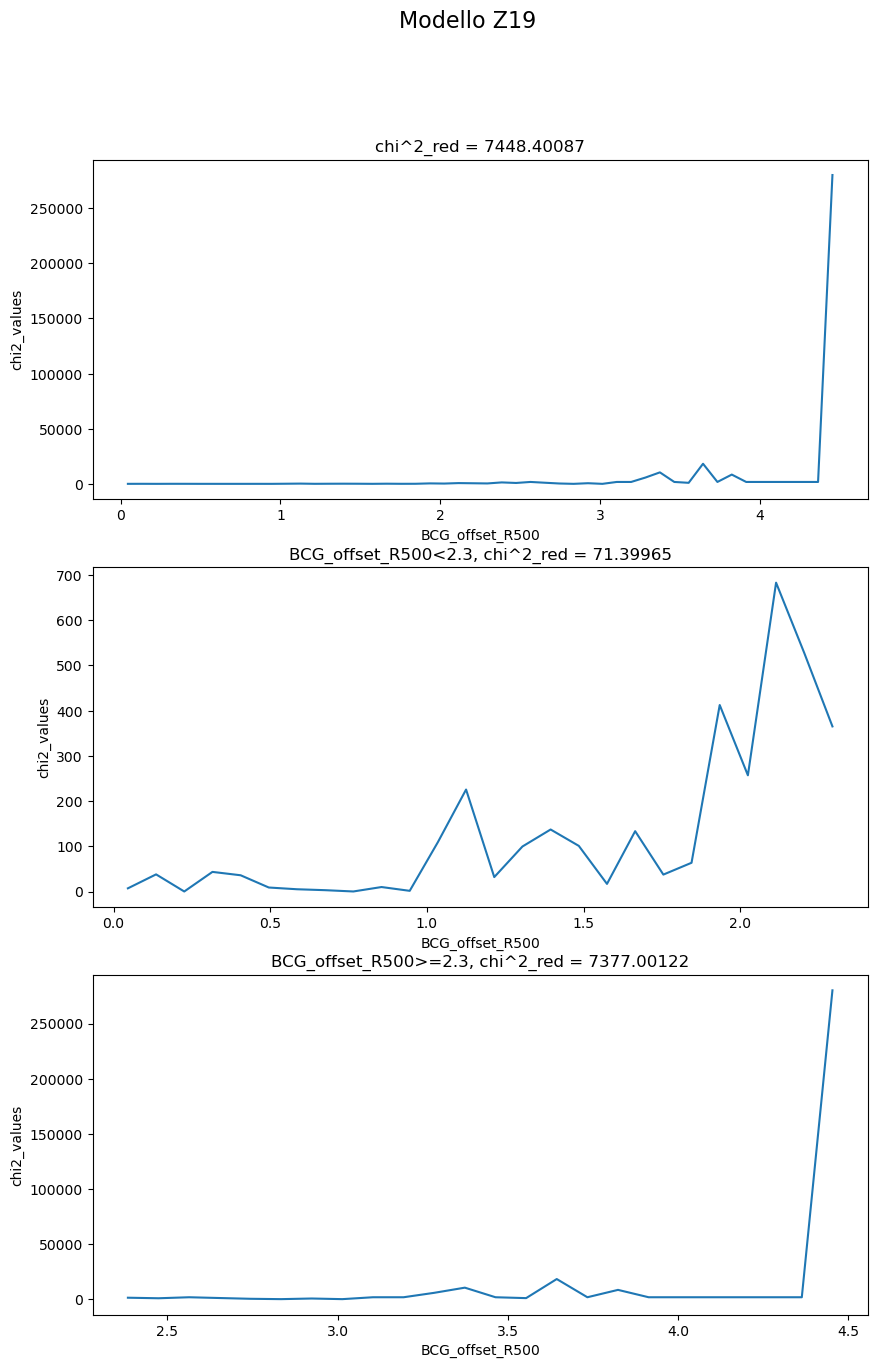

In [85]:
DoF = N_bins - 3  # number of bins - number of parameters

chi2_values_S15 = np.zeros(N_bins) #initialization
chi2_values_Z19 = np.zeros(N_bins) #initialization

threshold = 2.3

fig1, ax1 = plt.subplots(3, 1, figsize=(10, 15))
fig1.suptitle('Modello S15', fontsize=16)
fig2, ax2 = plt.subplots(3, 1, figsize=(10, 15))
fig2.suptitle('Modello Z19', fontsize=16)

for i in range(N_bins):
    chi2_values_S15[i] = np.power( hist[i] - y_arr_S15[i], 2) / var_model_S15[i]
    chi2_values_Z19[i] = np.power( hist[i] - y_arr_Z19[i], 2) / var_model_Z19[i]
    
value_S15 = np.sum(chi2_values_S15)

ax1[0].plot( bin_center, chi2_values_S15)
ax1[0].set_title('chi^2_red = {}'.format(np.round(value_S15 / DoF, 5)))
ax1[0].set_xlabel('BCG_offset_R500')
ax1[0].set_ylabel('chi2_values')

value_Z19 = np.sum(chi2_values_Z19)

ax2[0].plot( bin_center, chi2_values_Z19)
ax2[0].set_title('chi^2_red = {}'.format(np.round(value_Z19 / DoF, 5)))
ax2[0].set_xlabel('BCG_offset_R500')
ax2[0].set_ylabel('chi2_values')

xx = bin_center[bin_edges[:-1]<threshold]

chi2_values_S15 = np.zeros(len(xx)) #initialization
chi2_values_Z19 = np.zeros(len(xx)) #initialization

for i in range(len(xx)):
    chi2_values_S15[i] = np.power( hist[i] - y_arr_S15[i], 2) / var_model_S15[i]
    chi2_values_Z19[i] = np.power( hist[i] - y_arr_Z19[i], 2) / var_model_Z19[i]

value_S15 = np.sum(chi2_values_S15)

ax1[1].plot( xx, chi2_values_S15)
ax1[1].set_title('BCG_offset_R500<{}, chi^2_red = {}'.format(threshold, np.round(value_S15 / DoF, 5)))
ax1[1].set_xlabel('BCG_offset_R500')
ax1[1].set_ylabel('chi2_values')

value_Z19 = np.sum(chi2_values_Z19)

ax2[1].plot( xx, chi2_values_Z19)
ax2[1].set_title('BCG_offset_R500<{}, chi^2_red = {}'.format(threshold, np.round(value_Z19 / DoF, 5)))
ax2[1].set_xlabel('BCG_offset_R500')
ax2[1].set_ylabel('chi2_values')

xx = bin_center[bin_edges[:-1]>=threshold]

chi2_values_S15 = np.zeros(len(xx)) #initialization
chi2_values_Z19 = np.zeros(len(xx)) #initialization


for i in range(N_bins - len(xx), N_bins):
    chi2_values_S15[i - N_bins + len(xx)] = np.power( hist[i] - y_arr_S15[i], 2) / var_model_S15[i]
    chi2_values_Z19[i - N_bins + len(xx)] = np.power( hist[i] - y_arr_Z19[i], 2) / var_model_Z19[i]

value_S15 = np.sum(chi2_values_S15)

ax1[2].plot( xx, chi2_values_S15)
ax1[2].set_title('BCG_offset_R500>={}, chi^2_red = {}'.format(threshold, np.round(value_S15 / DoF, 5)))
ax1[2].set_xlabel('BCG_offset_R500')
ax1[2].set_ylabel('chi2_values')

value_Z19 = np.sum(chi2_values_Z19)

ax2[2].plot( xx, chi2_values_Z19)
ax2[2].set_title('BCG_offset_R500>={}, chi^2_red = {}'.format(threshold, np.round(value_Z19 / DoF, 5)))
ax2[2].set_xlabel('BCG_offset_R500')
ax2[2].set_ylabel('chi2_values')

plt.show()

Infine si sono fatti i seguenti plot: un grafico di comparazione con 0 e un grafico della funzione di fit in relazione al grafico, con le dovute incertezze. 

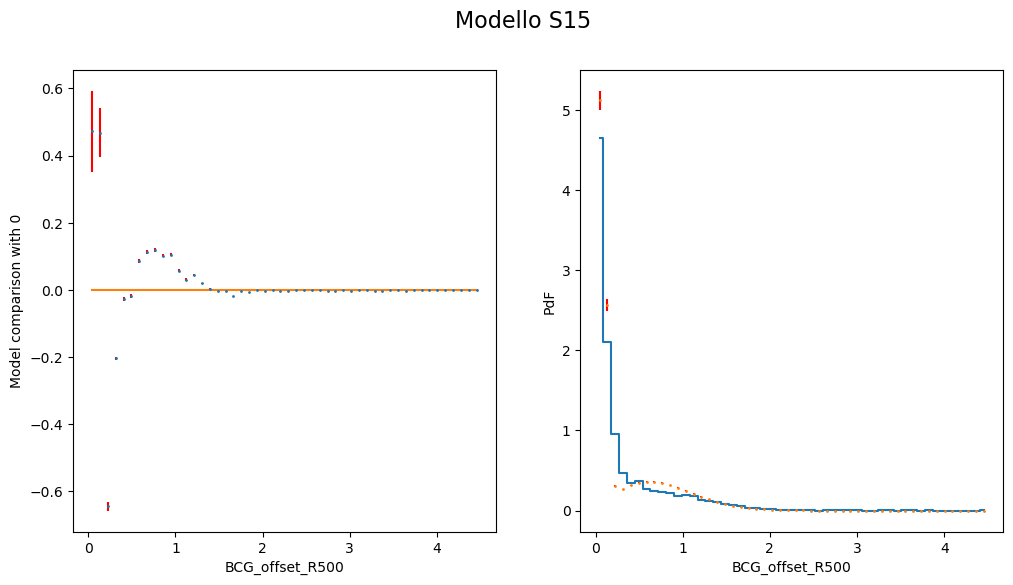

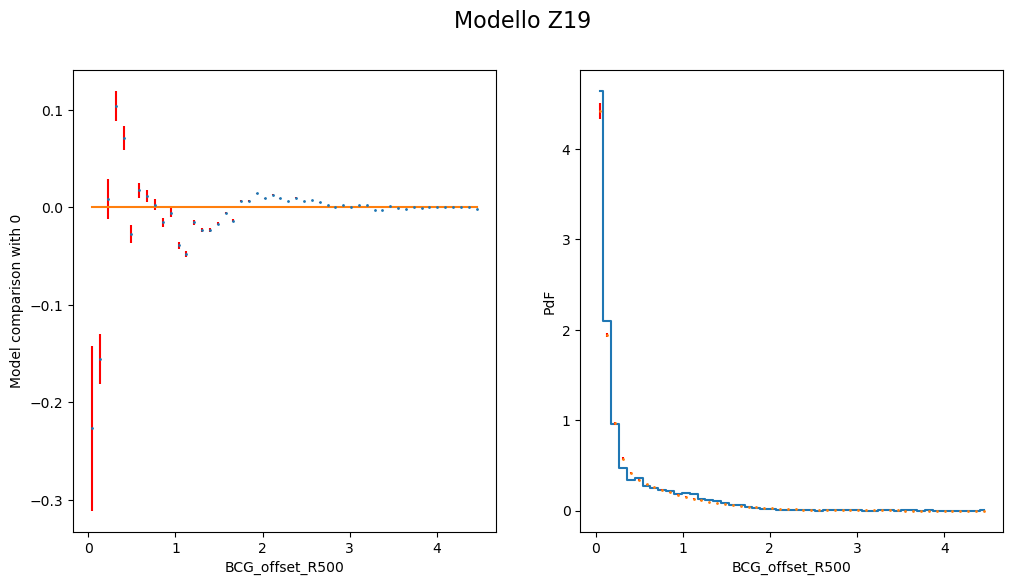

In [87]:
std_model_S15 = np.sqrt(var_model_S15)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Modello S15', fontsize=16)

ax[0].errorbar( bin_center, y_arr_S15 - hist, yerr = std_model_S15, ecolor="Red", fmt=".", markersize=2., label=None)
ax[0].plot(bin_center, np.zeros(N_bins))
ax[0].set_xlabel('BCG_offset_R500')
ax[0].set_ylabel('Model comparison with 0')

ax[1].step(bin_center, hist, data=None, where='mid')
ax[1].errorbar( bin_center, y_arr_S15, yerr = std_model_S15, ecolor="Red", fmt=".", markersize=2., label=None)
ax[1].set_xlabel('BCG_offset_R500')
ax[1].set_ylabel('PdF')

plt.show()

std_model_Z19 = np.sqrt(var_model_Z19)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Modello Z19', fontsize=16)

ax[0].errorbar( bin_center, y_arr_Z19 - hist, yerr = std_model_Z19, ecolor="Red", fmt=".", markersize=2., label=None)
ax[0].plot(bin_center, np.zeros(N_bins))
ax[0].set_xlabel('BCG_offset_R500')
ax[0].set_ylabel('Model comparison with 0')

ax[1].step(bin_center, hist, data=None, where='mid')
ax[1].errorbar( bin_center, y_arr_Z19, yerr = std_model_Z19, ecolor="Red", fmt=".", markersize=2., label=None)
ax[1].set_xlabel('BCG_offset_R500')
ax[1].set_ylabel('PdF')

plt.show()

## Commenti Finali

Come si è potuto notare dalla precedente analisi, i valori del $\chi^2_{red}$ dei 2 modelli ci suggeriscono che i fit non siano accettabili come rappresentazione dei dati. 

Tra i due fit il migliore è quello del modello Z19

Entrambi i modelli hanno gli stessi limiti: 
- la coda non è ben descritta, infatti i valori di $\chi^2_{red}$ vengono determinati principalmente dalla parte dell'istogramma dopo il valore di soglia. Ciò è dovuto dal fatto che, come si è notato nei precedenti grafici della varianza dei 2 modelli, essa decresce in maniera esponenziale (S15 $\approx e^{-x^2}$  ,  Z19 $\approx e^{-x}$).
- dalla comparazione con 0 si può evincere che l'incertezza del modello calcolata sia dunque una sottostima.

Un modo per migliorare la funzione di fit potrebbe essere quello di usare delle funzioni che decrescano più dolcemente, come delle polinomiali ad esponente negativo, magari al posto della funzione "centered", che nel modello Z19 sembra molto simile alla funzione di cauchy centrata in 0, ma normalizzata per avere solo valori positivi di x.

## Problemi riscontrati

La LogLikelihood è costruita sui dati (non sull'istogramma) però la bontà del fi (con il $\chi^2_{red}$) è calcolata basandosi sull'istogramma.
In questi giorni ho provato pure a costruire la Binned LogLikelihood $= cost + \sum_i n_i \cdot ln( \  MOD \ (x_{bin, i}| \rho, \sigma_0, \sigma_1) $ ma, pur trovando valori di parametri molto simili, non riuscivo ad esplorare lo spazio dei parametri con l'algoritmo emcee, motivo per cui ho dovuto usare una Unbinned LogLikelihood.